# 1. Create the design in Metal


### 1.1 Preload libraries and classes, then open Metal


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, MetalGUI
from qiskit_metal import Dict, Headings

In [3]:
from qiskit_metal.renderers.renderer_ansys.ansys_renderer import QAnsysRenderer
QAnsysRenderer.default_options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.2,
 'y_buffer_width_mm': 0.2,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [4]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

### 1.2 Prepare a design consisting of 4 qubits and 4 CPWs

In [5]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander

In [6]:
design.variables['cpw_width'] = '15 um'
design.variables['cpw_gap'] = '9 um'


In [7]:
# Enable overwrite, so that we can re-un this cell multiple times without incurring object name collisions
design.overwrite_enabled = True

# We now define the same custom options for all the transmons.
# We only list the options we intend to modify with respect to the default values
options = Dict(
    pad_width = '425 um',
    pocket_height = '650um',
    # Adding 3 connection_pads
    connection_pads=Dict(
        a = dict(loc_W=+1,loc_H=-1, pad_width='200um'),
        b = dict(loc_W=-1,loc_H=+1, pad_height='30um'),
        c = dict(loc_W=-1,loc_H=-1, pad_height='50um')
    )
)

# Create the 4 transmons
q1 = TransmonPocket(design, 'Q1', options = dict(
    pos_x='+2.42251mm', pos_y='+0.0mm', **options))
q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x='+0.0mm', pos_y='-0.95mm', orientation = '270', **options))
q3 = TransmonPocket(design, 'Q3', options = dict(
    pos_x='-2.42251mm', pos_y='+0.0mm', orientation = '180', **options))
q4 = TransmonPocket(design, 'Q4', options = dict(
    pos_x='+0.0mm', pos_y='+0.95mm', orientation = '90', **options))
gui.rebuild()
gui.autoscale()

In [8]:
# We define a handy method to shorten the number of line of code necessary to define the 4 CPW
def connect(component_name: str, component1: str, pin1: str, component2: str, pin2: str,
            length: str, asymmetry='0 um', flip=False, fillet='80um'):
    """Connect two pins with a CPW."""
    myoptions = Dict(
        fillet=fillet,
        hfss_wire_bonds = True,
        pin_inputs=Dict(
            start_pin=Dict(
                component=component1,
                pin=pin1),
            end_pin=Dict(
                component=component2,
                pin=pin2)),
        total_length=length)
    myoptions.update(options)
    myoptions.meander.asymmetry = asymmetry
    myoptions.meander.lead_direction_inverted = 'true' if flip else 'false'
    return RouteMeander(design, component_name, myoptions)

# Create the 4 CPWs
asym = 140
cpw1 = connect('cpw1', 'Q1', 'c', 'Q2', 'b', '5.6 mm', f'+{asym}um')
cpw2 = connect('cpw2', 'Q3', 'b', 'Q2', 'c', '5.7 mm', f'-{asym}um', flip=True)
cpw3 = connect('cpw3', 'Q3', 'c', 'Q4', 'b', '5.6 mm', f'+{asym}um')
cpw4 = connect('cpw4', 'Q1', 'b', 'Q4', 'c', '5.7 mm', f'-{asym}um', flip=True)

# Render the entire design to the Qiskit Metal GUI
gui.rebuild()
gui.autoscale()

10:36AM 56s WARNING [check_lengths]: For path table, component=cpw1, key=trace has short segments that could cause issues with fillet. Values in (1-1) (19-19)  are index(es) in shapely geometry.
10:36AM 56s WARNING [check_lengths]: For path table, component=cpw1, key=cut has short segments that could cause issues with fillet. Values in (1-1) (19-19)  are index(es) in shapely geometry.
10:36AM 56s WARNING [check_lengths]: For path table, component=cpw2, key=trace has short segments that could cause issues with fillet. Values in (1-1) (19-19)  are index(es) in shapely geometry.
10:36AM 56s WARNING [check_lengths]: For path table, component=cpw2, key=cut has short segments that could cause issues with fillet. Values in (1-1) (19-19)  are index(es) in shapely geometry.
10:36AM 56s WARNING [check_lengths]: For path table, component=cpw3, key=trace has short segments that could cause issues with fillet. Values in (1-1) (19-19)  are index(es) in shapely geometry.
10:36AM 56s WARNING [check_le

# 2. Render into Ansys HFSS

### 2.1 Setup an Ansys project

In [46]:
fourq_hfss = design.renderers.hfss

In [38]:
fourq_hfss.open_ansys(path_var='ANSYSEM_ROOT211')

### 2.2 Connect the Metal renderer with the Ansys project


In [47]:
fourq_hfss.connect_ansys()

INFO 01:02PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:02PM [load_ansys_project]: 	Opened Ansys App
INFO 01:02PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 01:02PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Airplane/OneDrive - skku.edu/문서/Ansoft/
	Project:   Project1
INFO 01:02PM [connect_design]: 	Opened active design
	Design:    HFSSMetalDrivenModal [Solution type: DrivenModal]
INFO 01:02PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 01:02PM [connect]: 	Connected to project "Project1" and design "HFSSMetalDrivenModal" 😀 



### 2.3 Setup an Ansys HFSS design

In [48]:
fourq_hfss.add_eigenmode_design("HFSSMetalEigenmode")

INFO 01:02PM [connect_design]: 	Opened active design
	Design:    HFSSMetalEigenmode1 [Solution type: Eigenmode]
WARNING 01:02PM [connect_setup]: 	No design setup detected.
WARNING 01:02PM [connect_setup]: 	Creating eigenmode default setup.
INFO 01:02PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [49]:
fourq_hfss.add_drivenmodal_design("HFSSMetalDrivenModal")


INFO 01:03PM [connect_design]: 	Opened active design
	Design:    HFSSMetalDrivenModal1 [Solution type: DrivenModal]
WARNING 01:03PM [connect_setup]: 	No design setup detected.
WARNING 01:03PM [connect_setup]: 	Creating drivenmodal default setup.
INFO 01:03PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)


In [50]:
fourq_hfss.activate_eigenmode_design("HFSSMetalEigenmode")

INFO 01:03PM [connect_design]: 	Opened active design
	Design:    HFSSMetalEigenmode [Solution type: Eigenmode]


In [51]:
fourq_hfss.activate_drivenmodal_design("HFSSMetalDrivenModal")

INFO 01:03PM [connect_design]: 	Opened active design
	Design:    HFSSMetalDrivenModal [Solution type: DrivenModal]


### 2.4 Render some component from the Metal design

In [53]:
fourq_hfss.render_design()  # entire Metal design.

com_error:  (-2147352567, '예외가 발생했습니다.', (0, None, None, None, 0, -2147024381), None)


com_error: (-2147352567, '예외가 발생했습니다.', (0, None, None, None, 0, -2147024381), None)

In [32]:
fourq_hfss.clean_active_design()

In [35]:
fourq_hfss.render_design(['Q1'], [('Q1', 'b'), ('Q1', 'c')])  # single qubit with 2 endcaps.

In [36]:
fourq_hfss.clean_active_design()

In [37]:
fourq_hfss.render_design(['Q1', 'cpw1', 'Q2'], [('Q1', 'b'), ('Q2', 'c')])  # 2 qubits and 2 endcaps, one per qubit.

com_error:  (-2147352567, '예외가 발생했습니다.', (0, None, None, None, 0, -2147024381), None)


com_error: (-2147352567, '예외가 발생했습니다.', (0, None, None, None, 0, -2147024381), None)

In [38]:
fourq_hfss.clean_active_design()
fourq_hfss.render_design(['Q2'], [('Q2', 'a')], [('Q2', 'b', '70')])

In [39]:
design._chips['main']['size']['size_y'] = '6mm'

In [40]:
fourq_hfss.clean_active_design()
fourq_hfss.render_design([], [], box_plus_buffer=False)

com_error:  (-2147352567, '예외가 발생했습니다.', (0, None, None, None, 0, -2147024381), None)


com_error: (-2147352567, '예외가 발생했습니다.', (0, None, None, None, 0, -2147024381), None)

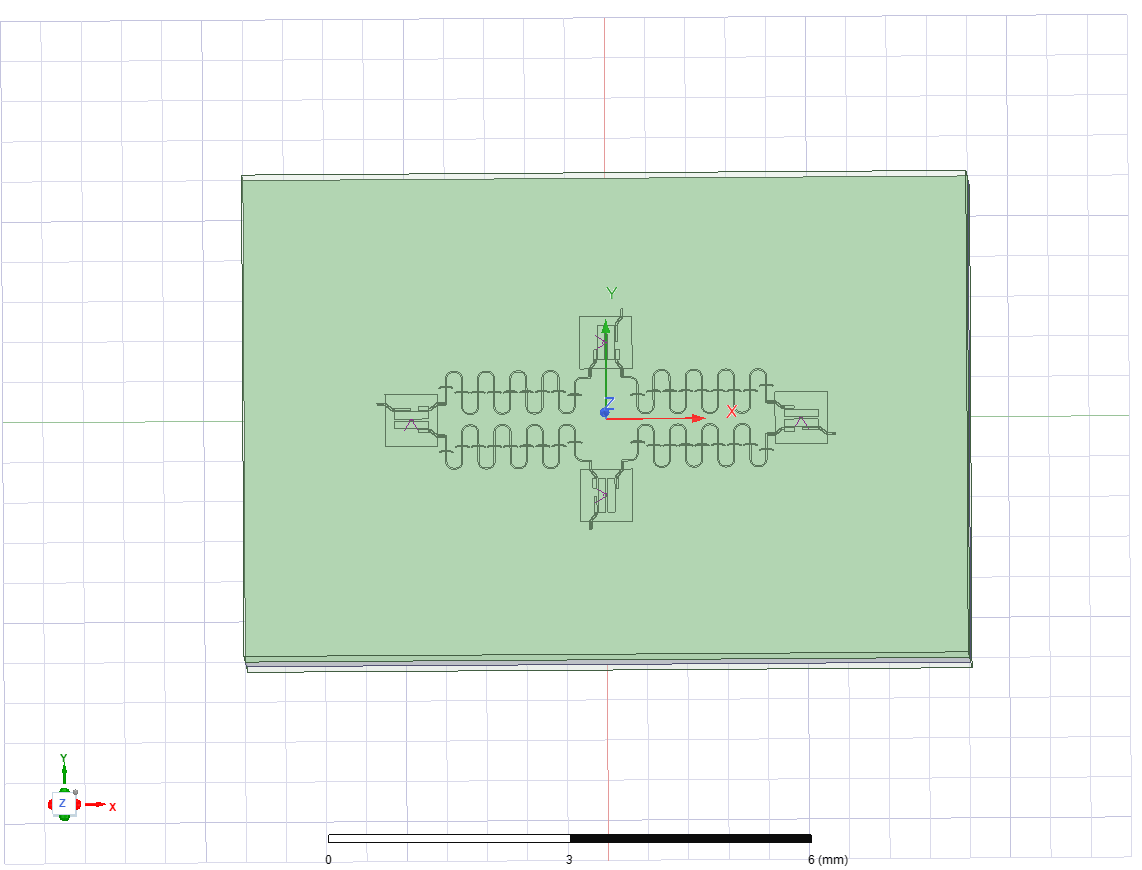

WindowsPath('C:/Users/Airplane/JupyterProject/ansys.png')

In [43]:
fourq_hfss.save_screenshot()

In [45]:
fourq_hfss.clean_active_design()
design._chips['main']['size']['size_x'] = '4mm'
fourq_hfss.render_design([], [], box_plus_buffer=False)
design._chips['main']['size']['size_x'] = '6mm'

com_error:  (-2147352567, '예외가 발생했습니다.', (0, None, None, None, 0, -2147024381), None)


com_error: (-2147352567, '예외가 발생했습니다.', (0, None, None, None, 0, -2147024381), None)

### 2.5 Create of select a setup

In [46]:
fourq_hfss.activate_eigenmode_design("HFSSMetalEigenmode")

INFO 03:57PM [connect_design]: 	Opened active design
	Design:    HFSSMetalEigenmode [Solution type: Eigenmode]


In [47]:
fourq_hfss.activate_eigenmode_setup('SetupNEW')

In [54]:
fourq_hfss.disconnect_ansys()

Warning! 9 COM references still alive
Ansys will likely refuse to shut down


01:05PM 51s WARNING [check_lengths]: For path table, component=cpw1, key=trace has short segments that could cause issues with fillet. Values in (1-1) (19-19)  are index(es) in shapely geometry.
01:05PM 51s WARNING [check_lengths]: For path table, component=cpw1, key=cut has short segments that could cause issues with fillet. Values in (1-1) (19-19)  are index(es) in shapely geometry.
01:06PM 05s WARNING [check_lengths]: For path table, component=cpw1, key=trace has short segments that could cause issues with fillet. Values in (1-1) (19-19)  are index(es) in shapely geometry.
01:06PM 05s WARNING [check_lengths]: For path table, component=cpw1, key=cut has short segments that could cause issues with fillet. Values in (1-1) (19-19)  are index(es) in shapely geometry.


# 3. Render into Ansys Q3D

In [50]:
fourq_q3d = design.renderers.q3d

### 3.1 Setup an Ansys project

In [52]:
fourq_q3d.open_ansys(path_var='ANSYSEM_ROOT211')

### 3.2 Connect the Q3D renderer with the Ansys project

In [53]:
fourq_q3d.connect_ansys()

INFO 04:18PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:18PM [load_ansys_project]: 	Opened Ansys App
INFO 04:18PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 04:18PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Airplane/OneDrive - skku.edu/문서/Ansoft/
	Project:   Project1
INFO 04:18PM [connect_design]: No active design found (or error getting active design).
INFO 04:18PM [connect]: 	 Connected to project "Project1". No design detected


# 3.3 Setup an Ansys Q3D design

In [54]:
fourq_q3d.add_q3d_design("Q3dMetalDesign")

INFO 04:19PM [connect_design]: 	Opened active design
	Design:    Q3dMetalDesign [Solution type: Q3D]
WARNING 04:19PM [connect_setup]: 	No design setup detected.
WARNING 04:19PM [connect_setup]: 	Creating Q3D default setup.
INFO 04:19PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)


In [55]:
fourq_q3d.activate_q3d_design("Q3dMetalDesign")

INFO 04:20PM [connect_design]: 	Opened active design
	Design:    Q3dMetalDesign [Solution type: Q3D]


### 3.4 Render some component from the Metal design

In [56]:
fourq_q3d.render_design()  # entire Metal design.

com_error:  (-2147352567, '예외가 발생했습니다.', (0, None, None, None, 0, -2147024381), None)


com_error: (-2147352567, '예외가 발생했습니다.', (0, None, None, None, 0, -2147024381), None)

In [57]:
fourq_q3d.clean_active_design()
fourq_q3d.render_design(['Q1'], [('Q1', 'b'), ('Q1', 'c')])  # single qubit with 2 endcaps.
#이 cell에서는 render design에서 에러가 발생하지 않음! - ??

In [59]:
fourq_q3d.clean_active_design()
fourq_q3d.render_design(['Q1', 'cpw1', 'Q2'], [('Q1', 'b'), ('Q2', 'c')])  # 2 qubits and 2 endcaps, one per qubit.


com_error:  (-2147352567, '예외가 발생했습니다.', (0, None, None, None, 0, -2147024381), None)


com_error: (-2147352567, '예외가 발생했습니다.', (0, None, None, None, 0, -2147024381), None)

In [60]:
fourq_q3d.clean_active_design()
fourq_q3d.render_design([], [], box_plus_buffer=False)

com_error:  (-2147352567, '예외가 발생했습니다.', (0, None, None, None, 0, -2147024381), None)


com_error: (-2147352567, '예외가 발생했습니다.', (0, None, None, None, 0, -2147024381), None)

In [61]:
fourq_q3d.clean_active_design()
design._chips['main']['size']['size_y'] = '4mm'
fourq_q3d.render_design([], [], box_plus_buffer=False)
#    Return back to original size, for the remainder of the notebook

com_error:  (-2147352567, '예외가 발생했습니다.', (0, None, None, None, 0, -2147024381), None)


com_error: (-2147352567, '예외가 발생했습니다.', (0, None, None, None, 0, -2147024381), None)

In [63]:
design._chips['main']['size']['size_y'] = '6mm'


### 3.5 Create of select a setup

In [64]:
fourq_q3d.activate_q3d_setup("SetupNEW")

In [65]:
fourq_q3d.disconnect_ansys()

Warning! 6 COM references still alive
Ansys will likely refuse to shut down


In [66]:
metal.about()


Qiskit Metal        0.0.4

Basic
____________________________________
 Python              3.9.5 (default, May 18 2021, 14:42:02) [MSC v.1916 64 bit (AMD64)]
 Platform            Windows AMD64
 Installation path   c:\users\airplane\qiskit-metal\qiskit_metal

Packages
____________________________________
 Numpy               1.20.2
 Qutip               4.6.2

Rendering
____________________________________
 Matplotlib          3.3.4

GUI
____________________________________
 PySide2 version     5.13.2
 Qt version          5.12.9
 SIP version         Not installed

IBM Quantum Team


'\nQiskit Metal        0.0.4\n\nBasic\n____________________________________\n Python              3.9.5 (default, May 18 2021, 14:42:02) [MSC v.1916 64 bit (AMD64)]\n Platform            Windows AMD64\n Installation path   c:\\users\\airplane\\qiskit-metal\\qiskit_metal\n\nPackages\n____________________________________\n Numpy               1.20.2\n Qutip               4.6.2\n\nRendering\n____________________________________\n Matplotlib          3.3.4\n\nGUI\n____________________________________\n PySide2 version     5.13.2\n Qt version          5.12.9\n SIP version         Not installed\n\nIBM Quantum Team'